# Integrating Orbits in a moving frame

This recipe is a minimum working example for integrating orbits in a moving frame. We will
1. Build the basis and coefficients from scratch
2. Implement a moving basis
3. Integrate orbits in the inertial frame

In [1]:
# some preliminaries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import pyEXP
import pyEXP

# check the version
pyEXP.util.getVersionInfo()


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% This is EXP 7.8.2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Repository URL | https://github.com/EXP-code/EXP                         %
%%%%% Current branch | fixAccelFunc                                            %
%%%%% Current commit | 9fe6efa40b841ae6d9874626aee5b44b5c09c81f                %
%%%%% Compile time   | 2025-04-22 09:59:33 BST                                 %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



In [3]:
lmax,nmax = 4,10

bconfig = """
---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: {}
  nmax: {}
  rmapping: 0.0667
  modelname: SLGridSph.model
  cachename: sphereSL.cache
...
""".format(lmax,nmax)

# Construct the basis instance
#
halo_basis   = pyEXP.basis.Basis.factory(bconfig)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.cache>
---- Spherical::orthoTest: worst=0.00016446


In [4]:
# now make a custom array of complex coefficients to install
lnumber = int((lmax+1)*(lmax+2)/2)
halo_coef_matrix = np.zeros([lnumber,nmax], dtype=np.complex128)

# set just the lowest-order term
halo_coef_matrix[0,0]=1.0


In [14]:
# make dummy coefficients for this basis to test orbits
halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(halo_coef, 'halo')

# check the time and center
print('Time:', halo_coef.getCoefTime())
print('Center:', halo_coef.getCoefCenter())

# the time and the center can be overridden here
halo_coef.setCoefTime(0.0) # the time can be overridden here
halo_coef.setCoefCenter([0.,0.,0.]) # the center can be overridden here
halo_coef.assign(halo_coef_matrix,lmax,nmax) # note that `assign` takes a matrix, even though getCoefs() returns a flattened vector

halo_coefs.add(halo_coef)
halo_coefs.WriteH5Coefs('outcoef.halo')


Time: 0.0
Center: [0.0, 0.0, 0.0]


Now let's duplicate those coefficients at a time in the future, but in a different location.

In [16]:

halo_coef = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0, center=[3.,0.,0.])
halo_coef.assign(halo_coef_matrix,lmax,nmax)

# pick a time way in the future...
halo_coef.setCoefTime(200.0)

# add the coefficients to the makecoefs instance
halo_coefs.add(halo_coef)
halo_coefs.ExtendH5Coefs('outcoef.halo')


Once the file is generated, we can read it back in going forward to save time.

In [21]:
cfile = 'outcoef.halo'
halo_coefs = pyEXP.coefs.Coefs.factory(cfile)

# let's check the centers after reading the file back in
print('T=0 center:',halo_coefs.getCoefStruct(0.0).getCoefCenter())
print('T=200 center:',halo_coefs.getCoefStruct(200.0).getCoefCenter())

T=0 center: [0.0, 0.0, 0.0]
T=200 center: [3.0, 0.0, 0.0]


In [26]:
# now we should have the ingredients that we need to integrate: a basis and a set of coefficients

# pick a phase space for some orbit:
ps = [[0.25,0,0,0,0.5,0.0]]

# set up the model with the basis and coefficients
model = [[halo_basis,halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,200.0,0.01
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, func)

Text(0, 0.5, 'y')

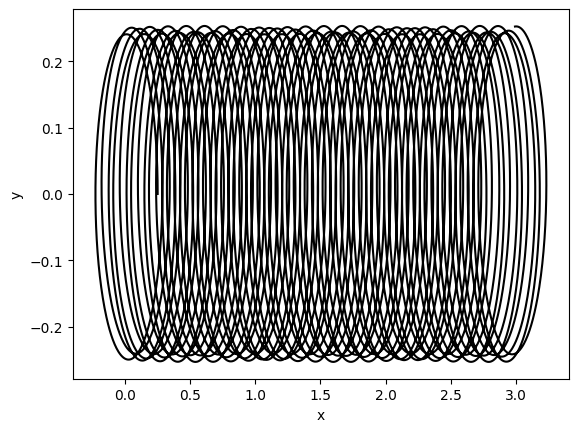

In [27]:
plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')

How did I pick those ICs? I used the circular velocity curve as a guide to find an orbit with some eccentricity (but not too much).

[0.0]
2000 1


Text(0, 0.5, 'circular velocity')

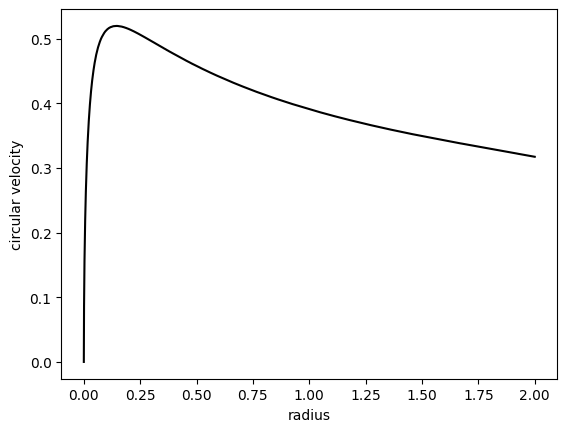

In [28]:
# make a circular velocity curve to get a velocity sense
pmin  = [0.0, 0.0, 0.0]
pmax  = [2.0, 0.0, 0.0]

# grid samples (sliced because last index is 0)
grid  = [2000,  0, 1]

indx = 0
times = [0.0]
print(times)
fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid) # note: this is always in the frame of the basis
surfaces = fields.slices(halo_basis, halo_coefs)

# Get the shape
keys = list(surfaces.keys())
nx = surfaces[keys[0]]['dens'].shape[0]
ny = surfaces[keys[0]]['dens'].shape[1]
print(nx,ny)

v = keys[0]
mapvals = surfaces[v]['rad force']#/surfaces0[v0]['dens m=0']
radii = np.linspace(0.0, 2.0, nx)
plt.plot(radii,np.sqrt(radii*np.abs(surfaces[v]['rad force'][:,0])),color='black')
plt.xlabel('radius')
plt.ylabel('circular velocity')